In [2]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from models.world_dit import WorldDiT

# model = WorldDiT(enable_cfg=False).to(device)
# model.load_state_dict(
#     torch.load("checkpoints/world_flow_base_20251201_170006/model_3000.pth")
# )

# CFG

model = WorldDiT(enable_cfg=True).to(device)
model.load_state_dict(
    torch.load("checkpoints/world_flow_clsfg_20251203_152551/model_3000.pth")
)

<All keys matched successfully>

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 444.52it/s]

[7712] Action: 0, up


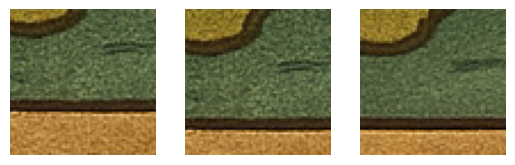

In [26]:
from train.world_flow import world_flow_sample
from dataset import WorldDataset, SelectSampleDataset

# import random

torch.manual_seed(42)

dataset = WorldDataset("data/world_map.png")
dataset = SelectSampleDataset(dataset, num_samples=16)

flow_steps = 10
# only show the final step
final_step = flow_steps - 1
steps_to_show = [final_step]

x0 = torch.randn(1, 3, 64, 64).to(device)

idx = random.randint(0, len(dataset))
# idx = 8341
start, action, end = dataset[idx]
start = start.to(device).unsqueeze(0)
action = torch.tensor(action).to(device).unsqueeze(0)

snapshots = world_flow_sample(
    x0,
    model,
    start,
    action,
    flow_steps,
    steps_to_show,
)

fig, axes = plt.subplots(1, 3)
# dont show axes
for ax in axes.flat:
    ax.axis("off")

start = start.squeeze(0)
action_str = (
    "up"
    if action.item() == 0
    else "down"
    if action.item() == 1
    else "left"
    if action.item() == 2
    else "right"
)
print(f"[{idx}] Action: {action.item()}, {action_str}")
axes[0].imshow(start.permute(1, 2, 0).cpu().numpy())
axes[1].imshow(end.permute(1, 2, 0).cpu().numpy())
axes[2].imshow(snapshots[final_step].permute(1, 2, 0).cpu().numpy())

100%|██████████| 10/10 [00:00<00:00, 456.25it/s]


[5136] Action: 0, up


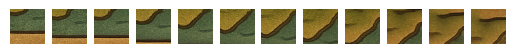

In [15]:
from train.world_flow import world_flow_sample
from dataset import WorldDataset, SelectSampleDataset

import random

torch.manual_seed(42)

dataset = WorldDataset("data/world_map.png")
dataset = SelectSampleDataset(dataset, num_samples=16)

flow_steps = 10
final_step = flow_steps - 1
# only show the final step
steps_to_show = [final_step]


idx = random.randint(0, len(dataset))
# idx = 8341
# idx = 5567
# idx = 2882
# idx = 5702
start, action, end = dataset[idx]
start = start.to(device).unsqueeze(0)
action = torch.tensor(action).to(device).unsqueeze(0)

rollout_steps = 10

rollout_imgs = []
prev = start
for step in range(rollout_steps):
    xt = torch.randn(1, 3, 64, 64).to(device)
    snapshots = world_flow_sample(
        xt,
        model,
        prev,
        action,
        flow_steps,
        steps_to_show,
    )
    rollout_imgs.append(snapshots[final_step])
    prev = snapshots[final_step].unsqueeze(0)
    prev = prev * 255

fig, axes = plt.subplots(1, rollout_steps + 2)
# dont show axes
for ax in axes.flat:
    ax.axis("off")

start = start.squeeze(0)
action_str = (
    "up"
    if action.item() == 0
    else "down"
    if action.item() == 1
    else "left"
    if action.item() == 2
    else "right"
)
print(f"[{idx}] Action: {action.item()}, {action_str}")
axes[0].imshow(start.permute(1, 2, 0).cpu().numpy())
axes[1].imshow(end.permute(1, 2, 0).cpu().numpy())
for i in range(rollout_steps):
    axes[i + 2].imshow(rollout_imgs[i].permute(1, 2, 0).cpu().numpy())